<a href="https://colab.research.google.com/github/axeltanjung/learn_rag_lllm/blob/main/langgraph/Build_Multi_Agent_AI_Agent_Chatbot_with_External_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [ ]:
!pip install arxiv wikipedia

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [5]:
# Using Arxiv and Wikipedia

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_charts_max = 300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_charts_max = 300)
wikipedia_tool = WikipediaQueryRun(api_wrapper = wikipedia_wrapper)

In [8]:
wikipedia_tool.invoke("Who is Ed Sheeran?")

'Page: Ed Sheeran\nSummary: Edward Christopher Sheeran  ( SHEER-ən; born 17 February 1991) is an English singer-songwriter. Born in Halifax, West Yorkshire, and raised in Framlingham, Suffolk, he began writing songs around the age of eleven. In early 2011, Sheeran independently released the extended play No. 5 Collaborations Project. He signed with Asylum Records the same year.\nSheeran\'s debut album, + ("Plus"), was released in September 2011 and topped the UK Albums Chart. It contained his first hit single "The A Team". In 2012, Sheeran won the Brit Awards for Best British Male Solo Artist and British Breakthrough Act. Sheeran\'s second studio album, × ("Multiply"), topped charts around the world upon its release in June 2014. It was named the second-best-selling album worldwide of 2015. In the same year, × won Album of the Year at the 2015 Brit Awards, and he received the Ivor Novello Award for Songwriter of the Year from the British Academy of Songwriters, Composers and Authors. A

In [9]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers."

In [10]:
tools = [wikipedia_tool]

In [12]:
from langgraph.graph.message import add_messages
# Langgraph Application
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [13]:
from langgraph.graph import StateGraph, START, END

In [15]:
graph_builder = StateGraph(State)

In [16]:
from langchain_groq import ChatGroq

In [18]:
from google.colab import userdata
groq_api_key = userdata.get("GROQ_API_KEY")

In [19]:
llm=ChatGroq(groq_api_key=groq_api_key, model_name = "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x79272ce76950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79272ce92800>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [20]:
llm_with_tools = llm.bind_tools(tools=tools)

In [21]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [22]:
from langgraph.prebuilt import ToolNode, tools_condition

In [25]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node = ToolNode(tools = tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [26]:
graph = graph_builder.compile()

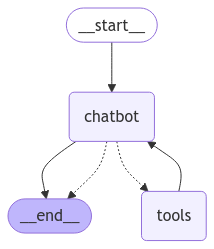

In [27]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))

except Exception:
  pass

In [31]:
user_input = "Hi there, my name is John"

events = graph.stream(
    {"messages":[("user", user_input)]}, stream_mode = "values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there, my name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9jsj)
 Call ID: call_9jsj
  Args:
    query: John


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_g2hg)
 Call ID: call_g2hg
  Args:
    query: John Doe
================================= Tool Message =================================
Name: wikipedia

Page: John Doe
Summary: John Doe (male) and Jane Doe (female) are multiple-use placeholder names that are used in the British and US-American legal system and aside generally in the United Kingdom and the United States when the true name of a person is unknown or is being intentionally concealed. In the context of law enforcement in the United States, such names are often used to refer to a corpse whose identity is unknown or cannot be confirmed. These names are also often used to refer to a hypothetical "everyman" in other contexts, like John Q. Public or "Joe Public". There are many varia